# 11/23/2024
Using scale, with only 2 degree deviation at j0 and j4 and no deviation at j1, j2, j3, j5, and make sure to take image from all angeles, works really good for now, will test other things as well.
7 images I took
- I tested with another data presented flat, and works really good
- now i test with a tilted data and it works really good, even if the joint travel are a lot and pose changes
- next i will test and see if the parameters are good for suronding points
- it is precise over different locations
- 
- now include rotation matrix in finding the optimized point, i want to see if dewer image will give me the same precision
- check if adding totation matrix in the T_cam_2_j4 will give me better result
- likelihood_3 is the best it does not consider rotation, only transation data and also the full eulelr 
- scale is not good for likelihood_3
- likelihood_3 with no scale, and take many images, it works really well
- 



In [1]:
#%matplotlib widget
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.optimize import differential_evolution, minimize

from IPython.display import display, clear_output

from dorna_vision import Detection
from camera import Camera
from dorna2 import Dorna
import itertools

"""
helper functions
"""
# euler to transformation matrix
def euler_matrix(xyzabc):
    if len(xyzabc) == 6:
        cv0 = np.pi/2 - xyzabc[3]
        sv0 = 1- cv0**2 / 2
        sv1 = xyzabc[4] 
        cv1 = 1 - sv1**2 / 2
        sv2 = xyzabc[5] 
        cv2 = 1 - sv2**2 / 2

        retval = np.matrix([
                [cv1* cv0   , sv2*sv1*cv0 - cv2*sv0 , cv2*sv1*cv0 - sv2*sv0 , xyzabc[0]],
                [cv1 * sv0  , sv2*sv1*sv0 + cv2*cv0 , cv2*sv1*sv0 + sv2*cv0 , xyzabc[1]],
                [-sv1       , sv2*cv1               , cv2*cv1               , xyzabc[2]],
                [0,0,0,1]])
    else:
        retval = np.matrix([
                [0 , -1 , 0, xyzabc[0]],
                [1, 0, 0, xyzabc[1]],
                [0, 0, 1, xyzabc[2]],
                [0,0,0,1]])         
    return retval    


def Euler_matrix(abg,xyz):
    cv0 = np.cos(abg[0])
    sv0 = np.sin(abg[0]) 
    cv1 = np.cos(abg[1]) 
    sv1 = np.sin(abg[1]) 
    cv2 = np.cos(abg[2])
    sv2 = np.sin(abg[2])
    return np.matrix([
        [cv1* cv0   , sv2*sv1*cv0 - cv2*sv0 , cv2*sv1*cv0 - sv2*sv0 , xyz[0]  ],
        [cv1 * sv0  , sv2*sv1*sv0 + cv2*cv0 , cv2*sv1*sv0 + sv2*cv0 , xyz[1]  ],
        [-sv1       , sv2*cv1               , cv2*cv1               , xyz[2]  ],
        [0,0,0,1]])

"""
j0_true = j0 + p[6]
j1_true = j1 + p[7]
j2_true = j2 + p[8]
j3_true = j3 + p[9]
j4_true = j4 + p[10]
"""
def likelihood(p, data):
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            if len(p) > 3:
                g = p[3]*d["A"] + (1-p[3])*np.array([d["kinematic"][0,3], d["kinematic"][1,3], d["kinematic"][2,3]]) + np.matmul( np.array(p[0:3]), d["B"]) 
            else:
                g = d["A"] + np.matmul( np.array(p[0:3]), d["B"]) 
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        #centroid = np.array([262.449615, -269.020641, 64.018827])
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        #total_error += np.std(d)
        total_error += np.mean(np.square(d))
    
    return total_error


def likelihood_2(p, data, robot): # rotation is also recorded
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            g_matrix = (d["kinematic"] @ np.matrix([[0, -p[3], 0, p[0]], [p[3], 0, 0, p[1]], [0, 0, p[3], p[2]], [0, 0, 0, 1]])) @ d["target_2_cam"]

            g = robot.kinematic.mat_to_xyzabc(g_matrix)
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    print("centroid: ", centroid)
    return total_error

# p: x, y, z, ej0, ej1, ej2, ej3, ej4, ej5, scale
# T: [[0 ,-scale, 0, x],[scale, 0, 0, y],[0, 0, scale, z],[0,0,0,1]]
def calibration_fast(p, data):
    # init
    total_error = 0
    num_data = 0
    for set in data:
        v =[]
        for d in set:
            g = ((d["H"][0]+p[3]*d["H"][1]+p[4]*d["H"][2]+p[5]*d["H"][3]+p[6]*d["H"][4]+p[7]*d["H"][5]) @ np.matrix([[p[1]], [-p[0]], [p[2]], [1]])).T
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    return total_error

# optimizing xyzabc
def transformation_calibration(p, data, ej=[0,0,0,0,0]): # no rotation only all the parameters for the euler matrix
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            if ej is [0,0,0,0,0]:
                kin = d["kinematic"]
            else:
                kin = d["jac"][0] + ej[0]*d["jac"][1] + ej[1]*d["jac"][2] + ej[2]*d["jac"][3] + ej[3]*d["jac"][4] + ej[4]*d["jac"][5]

            g = ((kin @ euler_matrix(p)) @ np.matrix([[d["gt"][0]], [d["gt"][1]], [d["gt"][2]], [1]])).T

            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    return total_error


def joint_calibration(p, data, T): # no rotation only all the parameters for the euler matrix
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:       
            kin = d["jac"][0] + p[0]*d["jac"][1] + p[1]*d["jac"][2] + p[2]*d["jac"][3] + p[3]*d["jac"][4] + p[4]*d["jac"][5]
            g = ((kin @ T) @ np.matrix([[d["gt"][0]], [d["gt"][1]], [d["gt"][2]], [1]])).T
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    return total_error


def likelihood_3(p, data, robot, calibration): # no rotation only all the parameters for the euler matrix
    # init
    total_error = 0
    num_data = 0

    for set in data:
        v =[]
        for d in set:
            
            ####### p[6]: ej0, p[7]: ej1, p[8]: ej2, p[9]: ej3, p[10]: ej4, p[11]: ej5
            if calibration:
                kin = d["jac"][0] + p[6]*d["jac"][1] + p[7]*d["jac"][2] + p[8]*d["jac"][3] + p[9]*d["jac"][4] + p[10]*d["jac"][5]
            else:
                kin = d["kinematic"]
            
            g = ((kin @ euler_matrix(p)) @ np.matrix([[d["gt"][0]], [d["gt"][1]], [d["gt"][2]], [1]])).T
            #######
            v.append(g)
            num_data = num_data + 1
    
        # compute centroid
        centroid = np.mean(v, axis=0)
        
        # compute distance
        d = [np.linalg.norm(g - centroid) for g in v]
        total_error += np.mean(np.square(d))
    
    return total_error


def minimizer(data, robot, type="calibration", scale=True, calibration=False):
    b = 5
    if type == "calibration_fast":
        # bounds
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (-b ,b),
                (-b ,b),
                (-b ,b),
                (-b ,b),
                (-b ,b),
                ]
        # return
        return differential_evolution(calibration_fast, bounds, args=(data, ), maxiter=1000, seed=42)

    if type == "calibration":
        # bounds
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (np.pi/2-0.05, np.pi/2+0.05),
                (-0.05, 0.05),
                (-0.05, 0.05),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                ]
        # init
        ej = [0,0,0,0,0]
        for _ in range(10):
            # transformer calibration
            result = differential_evolution(transformation_calibration, bounds[:6], args=(data, ej), maxiter=1000, seed=42)
            xyzabc = result.x.tolist()

            if not calibration:
                break
            
            # joint calibration
            T = euler_matrix(xyzabc)
            result = differential_evolution(joint_calibration, bounds[-5:], args=(data, T), maxiter=1000, seed=42)
            ej = result.x.tolist()

            print("error: ", result.fun)
        return np.append(xyzabc, ej), result.fun

    if type == "calibration_simple":
        # bounds
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                (-2 ,2),
                ]
        # init
        ej = [0,0,0,0,0]
        for _ in range(40):
            # transformer calibration
            result = differential_evolution(transformation_calibration, bounds[:3], args=(data, ej), maxiter=1000, seed=42)
            xyzabc = result.x.tolist()

            if not calibration:
                break
            
            # joint calibration
            T = euler_matrix(xyzabc)
            result = differential_evolution(joint_calibration, bounds[-5:], args=(data, T), maxiter=1000, seed=42)
            ej = result.x.tolist()

            print("error: ", result.fun)
        return np.append(xyzabc, ej), result.fun


    if type == "likelihood_3":
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (np.pi/2-0.05, np.pi/2+0.05),
                (-0.05, 0.05),
                (-0.05, 0.05),
                ]
        if calibration:
            bounds += 5*[(-2, 2)]
        return differential_evolution(likelihood_3, bounds, args=(data, robot, calibration), maxiter=1000, seed=42)


    # bounds
    if scale:
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b),
                (0.95, 1.05)
                ]
    else:
        bounds = [(robot.config["camera_mount"]["T"][0][3]-b, robot.config["camera_mount"]["T"][0][3]+b), 
                (robot.config["camera_mount"]["T"][1][3]-b, robot.config["camera_mount"]["T"][1][3]+b), 
                (robot.config["camera_mount"]["T"][2][3]-b, robot.config["camera_mount"]["T"][2][3]+b) 
                ]
    if type == "likelihood_2":
        return differential_evolution(likelihood_2, bounds, args=(data, robot), maxiter=1000, seed=42)
    elif type == "likelihood":
        result = differential_evolution(likelihood, bounds, args=(data,), maxiter=1000, seed=42)
        if calibration:
                x0 = result.x.tolist()+ 5*[0]
                bounds = [(result.x[0]-2, result.x[0]+2), 
                        (result.x[1]-2, result.x[1]+2), 
                        (result.x[2]-2, result.x[2]+2),
                        (result.x[3]-0.01, result.x[3]+0.01),
                        ]
                bounds += 5*[(-0.2, 0.2)]
                result = minimize(joint_calibration, x0=x0, args = (data,robot, ), bounds=bounds, method='L-BFGS-B', options={'maxiter': 1000, 'tol': 1e-3})    

    
    return result



def dorna_ta_eye_in_hand_camera_kit(robot, detection, target_joint_list, aruco_id):
    # init
    retval = []
    
    #go to init
    robot.set_motor(1)
    robot.sleep(1)


    pxl_target_2_cam_list = []
    # Generate all possible lists of size 5    
    for i in range(len(target_joint_list)):
        # move and sleep
        robot.jmove(rel=0, joint=target_joint_list[i], vel=50, accel=800, jerk=1000, cont=0)
        robot.sleep(0.2)

        # current joint
        joint = np.array(robot.get_all_joint()[0:6]).tolist()
        
        # run detection
        results = detection.run()
        if results:
            for result in results:
                if result["cls"] == str(int(aruco_id)) and result["xyz"][2] > 0:
                    # append collect data
                    retval.append({"joint": joint, "t_target_2_cam": result["xyz"], "aruco_t_target_2_cam": result["tvec"], "aruco_r_target_2_cam": result["rvec"]})
                    pxl_target_2_cam_list.append(result["center"])
                    break
            
        # draw centers
        for pxl in pxl_target_2_cam_list:
            cv2.circle(detection.img, (int(pxl[0]), int(pxl[1])), 5, (255,0,255), 2)

        # Clear the previous output
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(detection.img, cv2.COLOR_BGR2RGB)) # Display the image
        plt.axis('off')  # Turn off axis
        display(plt.gcf())  # Display the updated plot
        plt.close() # release the memory
        print("round: ", i+1, " / ", len(target_joint_list))

    return retval

def prepare_data(data, robot, use_aruco, thr=1.5):
    # remove large distance
    retval =[]
    for batch in data:
        tmp = list()
        for result in batch:
            # distance
            distance = np.linalg.norm(np.array(result["t_target_2_cam"])-np.array(result["aruco_t_target_2_cam"]))
            print("distance: ", distance)
            if distance >= thr:
                continue

            # target_to_camera
            if use_aruco:
                gt = result["aruco_t_target_2_cam"]
            else:
                gt = result["t_target_2_cam"]

            # target_2_cam
            target_2_cam = robot.kinematic.xyzabc_to_mat(np.array([gt[0], gt[1], gt[2], result["aruco_r_target_2_cam"][0], result["aruco_r_target_2_cam"][1], result["aruco_r_target_2_cam"][2]]))

            _kinematic = robot.kinematic.Ti_r_world(i=5, joint=result["joint"])

            # jacobian
            epsilon = 0.1
            joint_differential =  np.zeros((5, 6))

            for i in range(min(joint_differential.shape)):
                joint_differential[i, i] = epsilon

            jac = [_kinematic] 

            for i in range(min(joint_differential.shape)):
                diff_kin = (robot.kinematic.Ti_r_world(i=5, joint=(np.array(result["joint"])+joint_differential[i])) - jac[0])/epsilon
                jac.append(diff_kin)

            A = np.matmul(_kinematic[:3, :], np.matrix([[-gt[1]], [gt[0]], [gt[2]], [1]])).T
            B = _kinematic[:3, :3].T

            # H matrix
            H = []
            gt_matrix = np.matrix([[0, -1, 0, -gt[1]], [1, 0, 0, gt[0]], [0, 0, 1, gt[2]], [0, 0, 0, 1]])
            for i in range(len(jac)):
                H.append(np.matmul(jac[i], gt_matrix))
            
            # append
            tmp.append({"gt": gt, "A": A, "B": B, "kinematic": _kinematic, "joint": result["joint"], "target_2_cam": target_2_cam, "jac": jac, "H": H})
        
        if len(tmp) > 0:
            retval.append(tmp)
    return retval

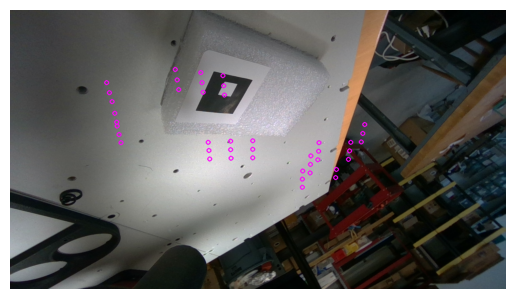

round:  45  /  45


In [ ]:
robot_ip = "192.168.254.87"
joint_recorded = [
#{"cmd": "tool", "lz":47.95}
#{"cmd": "tool", "lz":77.35}

{"cmd":"jmove","rel":0,"j0":-50.493164,"j1":27.663574,"j2":-99.909668,"j3":-3.032227,"j4":-16.765137,"j5":-9.953613},
{"cmd":"jmove","rel":0,"j0":-27.531738,"j1":19.841309,"j2":-103.07373,"j3":69.433594,"j4":15.754395,"j5":-9.953613},
{"cmd":"jmove","rel":0,"j0":-19.204102,"j1":26.652832,"j2":-111.181641,"j3":84.550781,"j4":31.574707,"j5":-9.931641},
{"cmd":"jmove","rel":0,"j0":-59.238281,"j1":22.763672,"j2":-73.168945,"j3":-81.210938,"j4":20.654297,"j5":-9.931641},
{"cmd":"jmove","rel":0,"j0":-37.30957,"j1":15.446777,"j2":-52.426758,"j3":-35.48584,"j4":-105.227051,"j5":-9.931641},
]
#joint_variance = [[-10, 0, 10], [0], [0], [0], [-10, 0, 10],[0]]
#joint_variance = [[-5, 0, 5], [0], [0,], [-5, 0, 5], [-5, 0, 5],[0]] # good result with scale
joint_variance = [[-2, 0, 2], [0], [0,], [0], [-2, 0, 2],[0]] # good result with scale
#joint_variance = [[0], [0], [0,], [0], [0],[0]] # test

joint_deviation = list(itertools.product(*joint_variance))
target_joint_list = []
for j in joint_recorded:
    target_joint_list += [(np.array([j["j0"], j["j1"], j["j2"], j["j3"], j["j4"], j["j5"]]) +  joint).tolist() for joint in joint_deviation]

"""
System parameters
"""
robot_model = "dorna_ta" # robot model

"""
aruco board parameters
"""
aruco_id = 17 # detected marker
aruco_length= 25 # length in mm
aruco_dic="DICT_4X4_100" # aruco type
aruco_refine="CORNER_REFINE_APRILTAG"
aruco_subpix=False


# collected data
collected_data = []

# camera
camera = Camera()

# Robot
robot = Dorna()

for _ in range(1):
    if not camera.connect():
        print("can not connect to camera")
        break
    else:
        print("camera connected")
    
    if not robot.connect(robot_ip):
        print("can not connect to robot")
        break
    else:
        print("robot connected")
    
    # detection
    prm = {'detection': {'cmd': 'aruco', 'dictionary': aruco_dic, 'marker_length': aruco_length, 'refine': aruco_refine, 'subpix': aruco_subpix}}
    detection = Detection(camera=camera, robot=None, **prm)

    # update collected data
    collected_data.append(dorna_ta_eye_in_hand_camera_kit(robot, detection, target_joint_list, aruco_id))  

# close the connections
camera.close()
robot.close()
detection.close()

In [40]:
# init
robot = Dorna()
calibration = True
scale = False
type = "calibration_fast"
use_aruco = True

# clean collected data
data = prepare_data(collected_data, robot, use_aruco=use_aruco, thr=0.25)
print("data size: ", sum([len(d) for d in data]))


result = minimizer(data, robot, type= type, scale=scale, calibration=calibration)
print("Optimal parameters:", result.x)
print("Objective function value:", result.fun)
ej = result.x[-5:].tolist()
T = euler_matrix(result.x[:3]).tolist()
"""

# transformation matrix
x, e = minimizer(data, robot, type= type, scale=scale, calibration=calibration)

T = euler_matrix(x[:6]).tolist()
ej = x[-5:].tolist()
# Output the results
print("Optimal parameters:", x)
print("Objective function value:", e)
"""

distance:  0.18424168412743805
distance:  0.16244336715332244
distance:  0.2393359911113532
distance:  0.1750617909399375
distance:  0.2291224382345769
distance:  0.09338228009231965
distance:  0.19519305448823301
distance:  0.17300693923237584
distance:  0.20223157357041438
distance:  0.20089015681924693
distance:  0.21723984417883893
distance:  0.20765028528239404
distance:  0.1807831757296069
distance:  0.1804189871677287
distance:  0.20451850816153175
distance:  0.15648070671153694
distance:  0.24229959708146678
distance:  0.22986783976060607
distance:  0.23735386420261523
distance:  0.12263587596531123
data size:  20
Optimal parameters: [47.82011106 29.67084892 -5.19590428 -5.         -0.35400415 -0.43234896
 -0.50268561 -0.26712845]
Objective function value: 0.7623128316626737


'\n\n# transformation matrix\nx, e = minimizer(data, robot, type= type, scale=scale, calibration=calibration)\n\nT = euler_matrix(x[:6]).tolist()\nej = x[-5:].tolist()\n# Output the results\nprint("Optimal parameters:", x)\nprint("Objective function value:", e)\n'

In [5]:
calibration = True
type = "calibration_fast"
x = np.array([49.043939358478305,
  29.8802360818961,
  -5.289141154371251,
  -0.5546563213026197,
  -1.9428709705642349,
  0.6989791244066615,
  -0.6205047967915083,
  -0.5067103802313175])

T = euler_matrix(x[:3]).tolist()
ej = x[-5:].tolist()
print(T)

[[0.0, -1.0, 0.0, 49.043939358478305], [1.0, 0.0, 0.0, 29.8802360818961], [0.0, 0.0, 1.0, -5.289141154371251], [0.0, 0.0, 0.0, 1.0]]


In [10]:
if type ==  "likelihood":
    T = [[0, -result.x[3], 0, result.x[0]],
        [result.x[3], 0, 0, result.x[1]],
        [0, 0, result.x[3], result.x[2]],
        [0, 0, 0, 1]]

camera_mount = {"type": "dorna_ta_j4", "T": T, "ej": ej}
#camera_mount = None
robot = Dorna()
print("Robot connected: ", robot.connect(robot_ip))
camera = Camera()

print("camera connected: ", camera.connect())

prm = {"camera_mount": camera_mount, 'detection': {'cmd': 'aruco', 'dictionary': aruco_dic, 'marker_length': aruco_length, 'refine': aruco_refine, 'subpix': aruco_subpix}}
detection = Detection(camera=camera, robot=robot, **prm)

retval = detection.run()
if retval:
    print('{"cmd":"lmove","rel":0,"x":'+str(retval[0]["xyz"][0])+',"y":'+str(retval[0]["xyz"][1])+',"z":'+str(retval[0]["xyz"][2])+'}')
    if calibration:
        print('{"cmd":"jmove","rel":1,"j0":'+str(-ej[0])+',"j1":'+str(-ej[1])+',"j2":'+str(-ej[2])+',"j3":'+str(-ej[3])+',"j4":'+str(-ej[4])+'}')


# close the connections
robot.close()
camera.close()
detection.close()


Robot connected:  True
camera connected:  True
{"cmd":"lmove","rel":0,"x":190.77073927741588,"y":-338.3595449285815,"z":2.2129104860191546}
{"cmd":"jmove","rel":1,"j0":0.5546563213026197,"j1":1.9428709705642349,"j2":-0.6989791244066615,"j3":0.6205047967915083,"j4":0.5067103802313175}


In [322]:
import pickle
with open('data.pkl', 'wb') as file:
    pickle.dump(collected_data, file)


In [5]:
import pickle

# Load the pickle file
with open('data_2.pkl', 'rb') as file:  # Use 'rb' to read the file
    collected_data = pickle.load(file)


In [2]:
robot_ip = "192.168.254.87"
joint_recorded = [
#{"cmd": "tool", "lz":47.95}
#{"cmd": "tool", "lz":77.35}

{"cmd":"jmove","rel":0,"j0":-50.493164,"j1":27.663574,"j2":-99.909668,"j3":-3.032227,"j4":-16.765137,"j5":-9.953613},
{"cmd":"jmove","rel":0,"j0":-27.531738,"j1":19.841309,"j2":-103.07373,"j3":69.433594,"j4":15.754395,"j5":-9.953613},
{"cmd":"jmove","rel":0,"j0":-19.204102,"j1":26.652832,"j2":-111.181641,"j3":84.550781,"j4":31.574707,"j5":-9.931641},
{"cmd":"jmove","rel":0,"j0":-59.238281,"j1":22.763672,"j2":-73.168945,"j3":-81.210938,"j4":20.654297,"j5":-9.931641},
{"cmd":"jmove","rel":0,"j0":-37.30957,"j1":15.446777,"j2":-52.426758,"j3":-35.48584,"j4":-105.227051,"j5":-9.931641},
]
#joint_variance = [[-10, 0, 10], [0], [0], [0], [-10, 0, 10],[0]]
#joint_variance = [[-5, 0, 5], [0], [0,], [-5, 0, 5], [-5, 0, 5],[0]] # good result with scale
joint_variance = [[-2, 0, 2], [0], [0,], [0], [-2, 0, 2],[0]] # good result with scale
#joint_variance = [[0], [0], [0,], [0], [0],[0]] # test

joint_deviation = list(itertools.product(*joint_variance))
target_joint_list = []
for j in joint_recorded:
    target_joint_list += [(np.array([j["j0"], j["j1"], j["j2"], j["j3"], j["j4"], j["j5"]]) +  joint).tolist() for joint in joint_deviation]

"""
System parameters
"""
robot_model = "dorna_ta" # robot model

"""
aruco board parameters
"""
aruco_id = 17 # detected marker
aruco_length= 25 # length in mm
aruco_dic="DICT_4X4_100" # aruco type
aruco_refine="CORNER_REFINE_APRILTAG"
aruco_subpix=False

In [12]:
T = np.matrix([[0.00525873615, -0.999894519, 0.0134620306, 46.5174596], [0.999959617, 0.00535678348, -0.0073579648, 32.0776662], [0.00728773209, -0.0135001806, 0.99988231, -4.24772615], [0.0, 0.0, 0.0, 1.0]])
result = robot.kinematic.mat_to_xyzabc(T)
print(result)

[46.5174596  32.0776662  -4.24772615 -0.27547989  0.27691881 89.6939516 ]


In [13]:
XT = robot.kinematic.xyzabc_to_mat(result)
print(XT)

[[ 5.33606541e-03 -9.99985763e-01  3.23873967e-05  4.65174596e+01]
 [ 9.99966899e-01  5.33616368e-03  6.14212992e-03  3.20776662e+01]
 [-6.14221530e-03 -3.88482399e-07  9.99981136e-01 -4.24772615e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [14]:
xresult = robot.kinematic.mat_to_xyzabc(XT)
print(xresult)

[46.5174596  32.0776662  -4.24772615 -0.27547989  0.27691881 89.6939516 ]


In [16]:
x = {"ali":1, "hasan":2}
x[0]

KeyError: 0

In [17]:
x = [46.5174596, 32.0776662, -4.24772615, -0.27547989, 0.27691881, 89.6939516, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
x[0:6]

[46.5174596, 32.0776662, -4.24772615, -0.27547989, 0.27691881, 89.6939516]

In [21]:
x[6:14]

[0, 0, 0, 0, 0, 0, 0, 0]